In [1]:
from __future__ import print_function
import datetime
import time
from functools import reduce
from collections import defaultdict
import os
import tqdm
import gzip
import pickle

import pyarrow.parquet as parquet
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numba

from fastset import FastSet

In [2]:
#   DBS BLOCKS table schema:
#     BLOCK_ID NOT NULL NUMBER(38)
#     BLOCK_NAME NOT NULL VARCHAR2(500)
#     DATASET_ID NOT NULL NUMBER(38)
#     OPEN_FOR_WRITING NOT NULL NUMBER(38)
#     ORIGIN_SITE_NAME NOT NULL VARCHAR2(100)
#     BLOCK_SIZE NUMBER(38)
#     FILE_COUNT NUMBER(38)
#     CREATION_DATE NUMBER(38)
#     CREATE_BY VARCHAR2(500)
#     LAST_MODIFICATION_DATE NUMBER(38)
#     LAST_MODIFIED_BY VARCHAR2(500)
if not os.path.exists('data/block_size.npy'):
    # numpy readcsv couldn't handle the size :(
    blocksize = pd.read_csv("data/dbs_blocks.csv", dtype='i8', usecols=(0,5), names=['block_id', 'block_size'])
    np.save('data/block_size.npy', blocksize.values)
    blocksize = blocksize.values
else:
    blocksize = np.load('data/block_size.npy')

# We'll be accessing randomly, make a fast lookup
bsort = np.argsort(blocksize[:,0])
bsize_index = FastSet(blocksize[bsort, 0])
bsize_values = blocksize[bsort, 1]
bsize_values = np.append(bsize_values, 0)
def getsize(s):
    return bsize_values[np.searchsorted(bsize_index._set, s._set)].sum()

In [3]:
blockmap_filename = 'data/blockmap.pkl'
if not os.path.exists(blockmap_filename):
    blockmap_in = pd.read_csv("data/dbs_blocks.csv", dtype='i8', usecols=(0,2), names=['block_id', 'dataset_id'])
    blockmap = defaultdict(FastSet)
    for bid, dsid in blockmap_in.values:
        blockmap[dsid] += FastSet([bid])

    del blockmap_in
    with gzip.open(blockmap_filename, 'wb') as fout:
        pickle.dump(blockmap, fout)
else:
    with gzip.open(blockmap_filename) as fin:
        blockmap = pickle.load(fin)

In [4]:
ws_cmssw = parquet.read_table('data/working_set_cmssw').to_pandas()
ws_cmssw['working_set_blocks'] = ws_cmssw.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [5]:
ws_fwjr = parquet.read_table('data/working_set_fwjr').to_pandas()
ws_fwjr['working_set_blocks'] = ws_fwjr.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [6]:
#ws_classads = parquet.read_table('data/working_set_classads').to_pandas()
#ws_classads['working_set_blocks'] = ws_classads.apply(
#    lambda x: sum((blockmap[ds] for ds in x.working_set), FastSet()), 'columns')

In [7]:
#ws_xrootd = parquet.read_table('data/working_set_xrootd').to_pandas()
#ws_xrootd['working_set_blocks'] = ws_xrootd.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [8]:
# join the data tier definitions
titles = ['id', 'data_tier', 'day', 'user']
datatiers = pd.read_csv('data/dbs_datatiers.csv', names=titles).set_index('id')

def add_datatiers(ws):
    ws['data_tier'] = datatiers.loc[ws.d_data_tier_id].data_tier.values
    
#add_datatiers(ws_classads)
add_datatiers(ws_cmssw)
#add_datatiers(ws_xrootd)
add_datatiers(ws_fwjr)

In [9]:
def filt(ws):
    return ws[ws['data_tier'].str.match('(|MINI|NANO)AOD')]

ws_cmssw_filt = filt(ws_cmssw)
ws_fwjr_filt = filt(ws_fwjr)

In [10]:
def dataByLoc(ws):
    data = ws.groupby('site_name').working_set_blocks.agg(lambda series: reduce(FastSet.union, series, FastSet())).map(getsize)
    return(data)

In [11]:
cmssw_set = dataByLoc(ws_cmssw)
fwjr_set = dataByLoc(ws_fwjr)
cmssw_set_filt = dataByLoc(ws_cmssw_filt)
fwjr_set_filt = dataByLoc(ws_fwjr_filt)

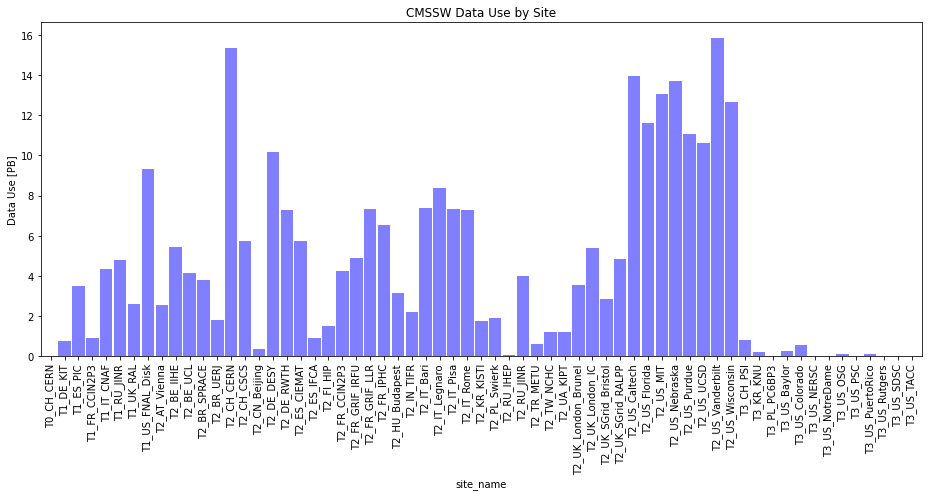

In [12]:
x = np.arange(len(cmssw_set))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
(cmssw_set/1e15).plot.bar(align='center', width=0.9, label='CMSSW', alpha=0.5, color='blue')

ax.set_ylabel('Data Use [PB]')
ax.set_title('CMSSW Data Use by Site')
ax.set_xticks(x)

fig.tight_layout()

fig.savefig("plots/site_cmssw.pdf")

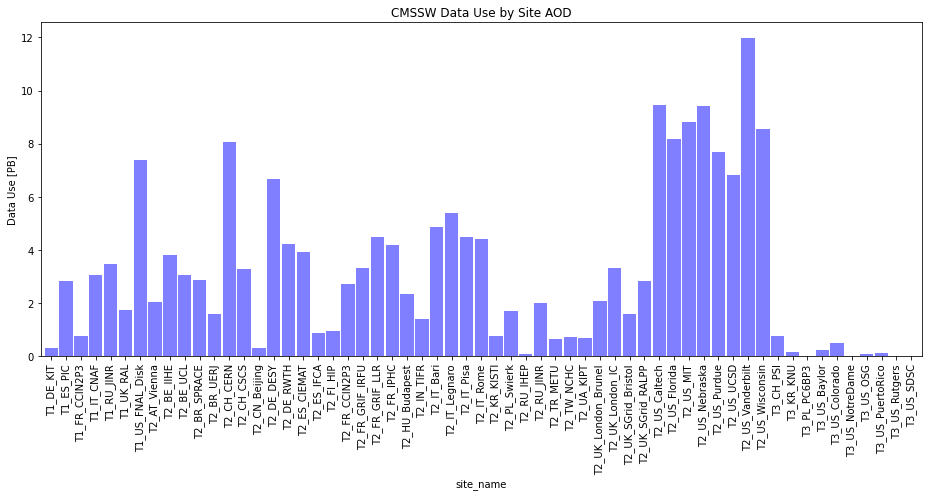

In [13]:
x = np.arange(len(cmssw_set_filt))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
(cmssw_set_filt/1e15).plot.bar(align='center', width=0.9, label='CMSSW', alpha=0.5, color='blue')

ax.set_ylabel('Data Use [PB]')
ax.set_title('CMSSW Data Use by Site AOD')
ax.set_xticks(x)

fig.tight_layout()

fig.savefig("plots/site_cmssw_aod.pdf")

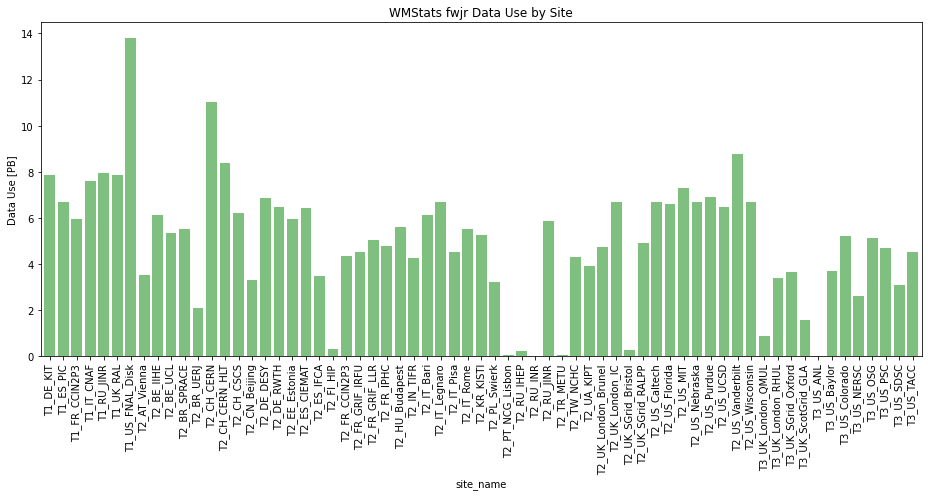

In [14]:
x = np.arange(len(fwjr_set))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
(fwjr_set/1e15).plot.bar(align='center', width=0.8, label='WMStats fwjr', alpha=0.5, color='green')

ax.set_ylabel('Data Use [PB]')
ax.set_title('WMStats fwjr Data Use by Site')
ax.set_xticks(x)

fig.tight_layout()

fig.savefig("plots/site_fwjr.pdf")

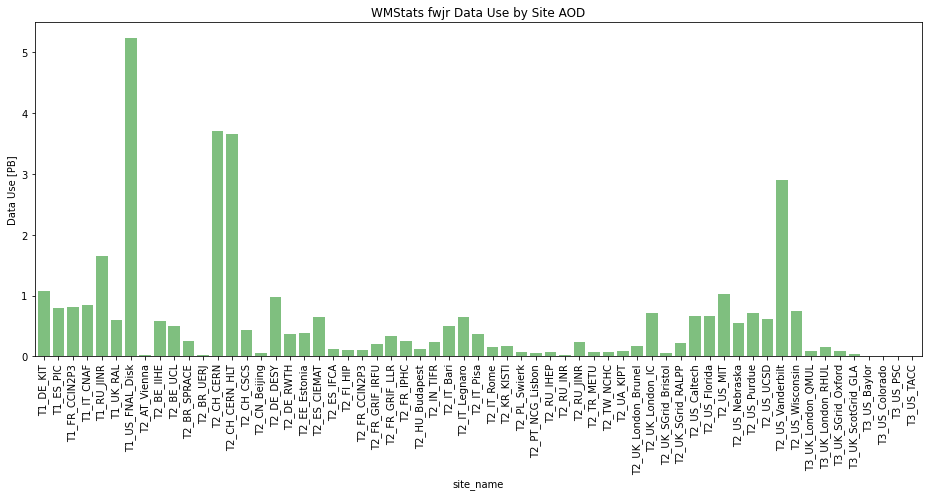

In [15]:
x = np.arange(len(fwjr_set_filt))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
(fwjr_set_filt/1e15).plot.bar(align='center', width=0.8, label='WMStats fwjr', alpha=0.5, color='green')

ax.set_ylabel('Data Use [PB]')
ax.set_title('WMStats fwjr Data Use by Site AOD')
ax.set_xticks(x)

fig.tight_layout()

fig.savefig("plots/site_fwjr_aod.pdf")

In [16]:
combined = pd.concat([cmssw_set.rename('cmssw')/1e15, fwjr_set.rename('fwjr')/1e15], axis=1).sort_index()
combined_filt = pd.concat([cmssw_set_filt.rename('cmssw')/1e15, fwjr_set_filt.rename('fwjr')/1e15], axis=1).sort_index()

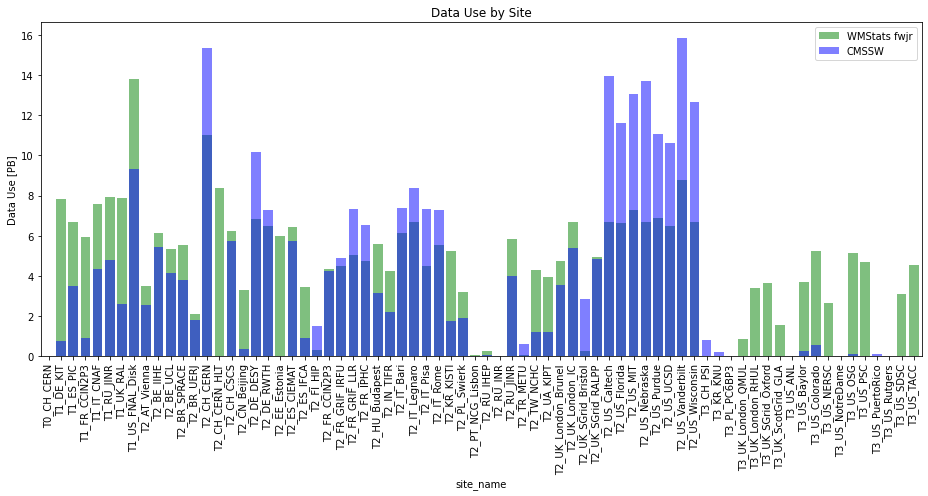

In [17]:
x = np.arange(len(combined.fwjr))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
combined.fwjr.plot.bar(align='center', width=0.8, label='WMStats fwjr', alpha=0.5, color='green')
combined.cmssw.plot.bar(align='center', width=0.8, label='CMSSW', alpha=0.5, color='blue')

ax.set_ylabel('Data Use [PB]')
ax.set_title('Data Use by Site')
ax.set_xticks(x)
ax.legend()

fig.tight_layout()
fig.savefig("plots/site_fwjr_cmssw.pdf")

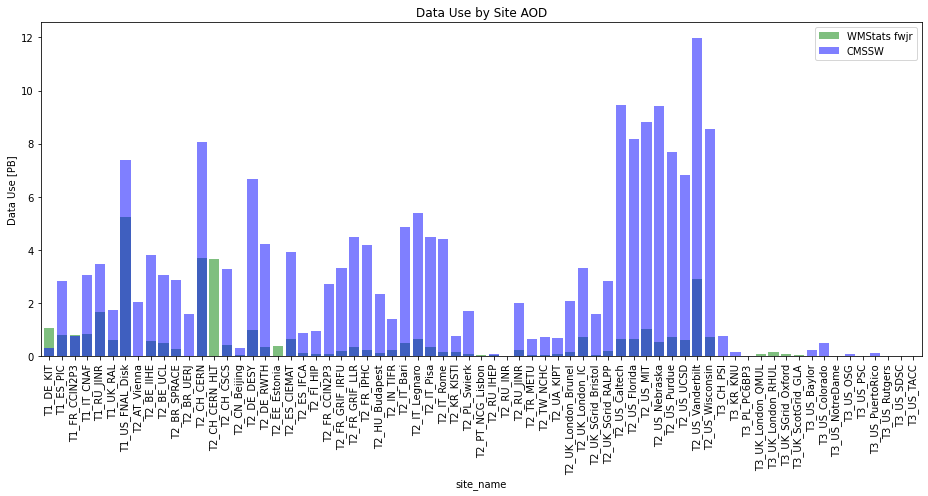

In [18]:
x = np.arange(len(combined_filt.fwjr))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
combined_filt.fwjr.plot.bar(align='center', width=0.8, label='WMStats fwjr', alpha=0.5, color='green')
combined_filt.cmssw.plot.bar(align='center', width=0.8, label='CMSSW', alpha=0.5, color='blue')

ax.set_ylabel('Data Use [PB]')
ax.set_title('Data Use by Site AOD')
ax.set_xticks(x)
ax.legend()

fig.tight_layout()
fig.savefig("plots/site_fwjr_cmssw_aod.pdf")

In [19]:
def crab(ws):
    return ws_cmssw.loc[ws_cmssw['is_crab'] == True]

In [20]:
cmssw_set_crab = dataByLoc(crab(ws_cmssw))
fwjr_set_crab = dataByLoc(crab(ws_fwjr))
cmssw_set_filt_crab = dataByLoc(crab(ws_cmssw_filt))
fwjr_set_filt_crab = dataByLoc(crab(ws_fwjr_filt))

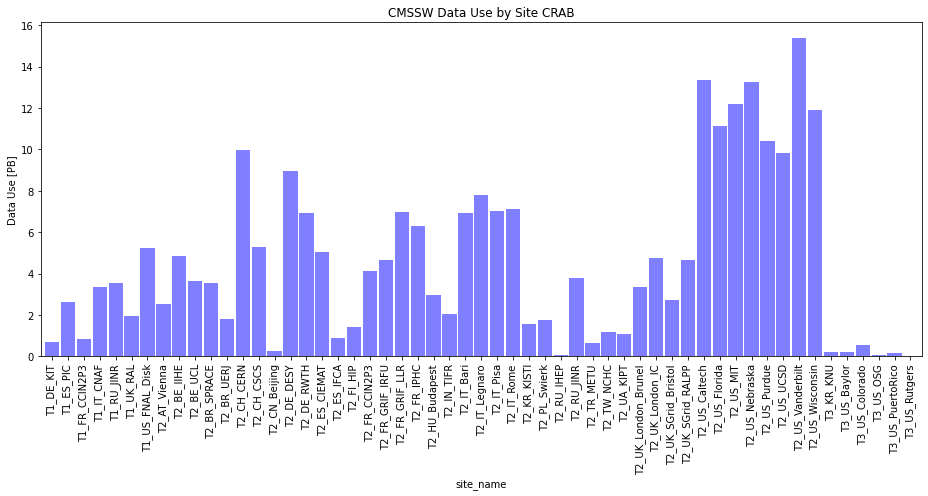

In [21]:
x = np.arange(len(cmssw_set_crab))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
(cmssw_set_crab/1e15).plot.bar(align='center', width=0.9, label='CMSSW', alpha=0.5, color='blue')

ax.set_ylabel('Data Use [PB]')
ax.set_title('CMSSW Data Use by Site CRAB')
ax.set_xticks(x)

fig.tight_layout()

fig.savefig("plots/site_cmssw_crab.pdf")

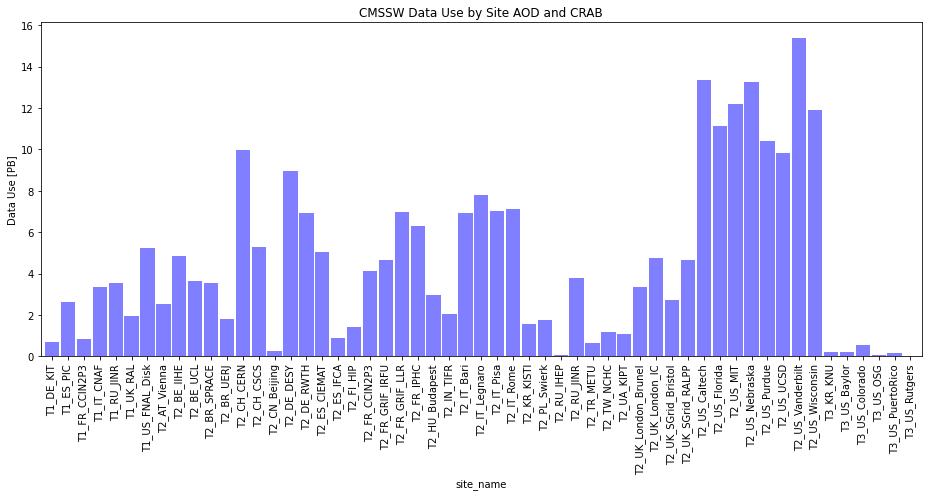

In [22]:
x = np.arange(len(cmssw_set_filt_crab))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
(cmssw_set_filt_crab/1e15).plot.bar(align='center', width=0.9, label='CMSSW', alpha=0.5, color='blue')

ax.set_ylabel('Data Use [PB]')
ax.set_title('CMSSW Data Use by Site AOD and CRAB')
ax.set_xticks(x)

fig.tight_layout()

fig.savefig("plots/site_cmssw_filt_crab.pdf")

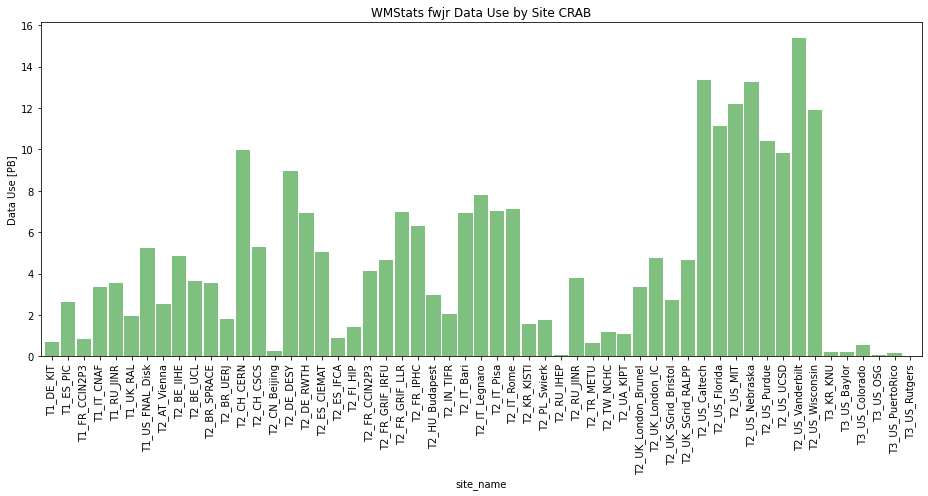

In [23]:
x = np.arange(len(fwjr_set_crab))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
(fwjr_set_crab/1e15).plot.bar(align='center', width=0.9, label='CMSSW', alpha=0.5, color='green')

ax.set_ylabel('Data Use [PB]')
ax.set_title('WMStats fwjr Data Use by Site CRAB')
ax.set_xticks(x)

fig.tight_layout()

fig.savefig("plots/site_fwjr_crab.pdf")

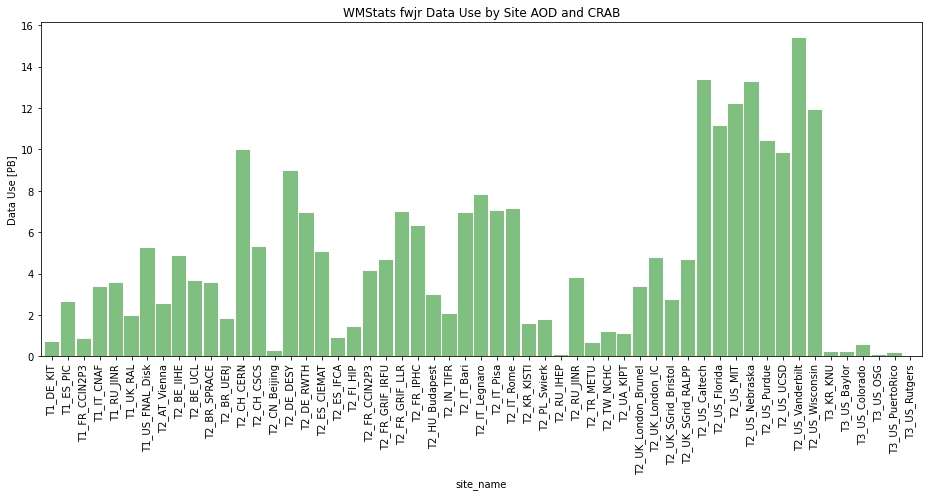

In [24]:
x = np.arange(len(fwjr_set_filt_crab))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
(fwjr_set_filt_crab/1e15).plot.bar(align='center', width=0.9, label='CMSSW', alpha=0.5, color='green')

ax.set_ylabel('Data Use [PB]')
ax.set_title('WMStats fwjr Data Use by Site AOD and CRAB')
ax.set_xticks(x)

fig.tight_layout()

fig.savefig("plots/site_fwjr_filt_crab.pdf")

In [25]:
combined_crab = pd.concat([cmssw_set_crab.rename('cmssw')/1e15, fwjr_set_crab.rename('fwjr')/1e15], axis=1).sort_index()
combined_filt_crab = pd.concat([cmssw_set_filt_crab.rename('cmssw')/1e15, fwjr_set_filt_crab.rename('fwjr')/1e15], axis=1).sort_index()

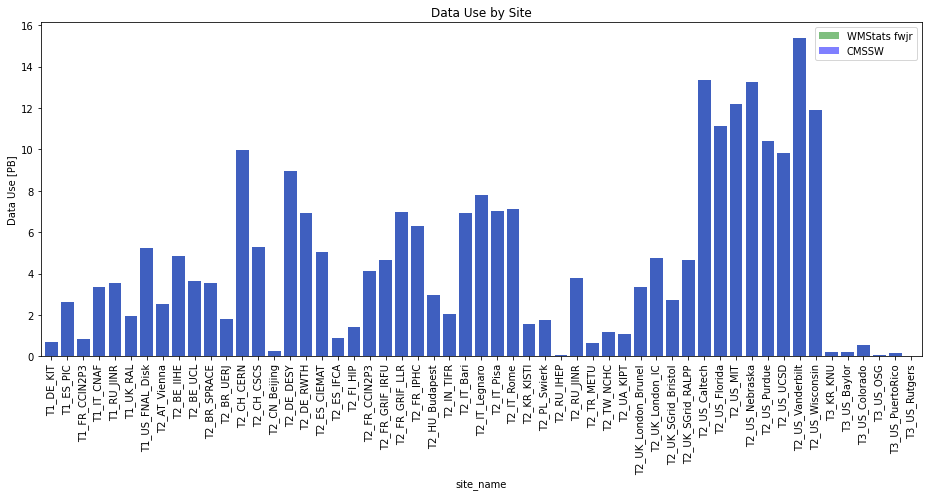

In [26]:
x = np.arange(len(combined_crab.fwjr))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
combined_crab.fwjr.plot.bar(align='center', width=0.8, label='WMStats fwjr', alpha=0.5, color='green')
combined_crab.cmssw.plot.bar(align='center', width=0.8, label='CMSSW', alpha=0.5, color='blue')

ax.set_ylabel('Data Use [PB]')
ax.set_title('Data Use by Site')
ax.set_xticks(x)
ax.legend()

fig.tight_layout()
fig.savefig("plots/site_fwjr_cmssw_crab.pdf")

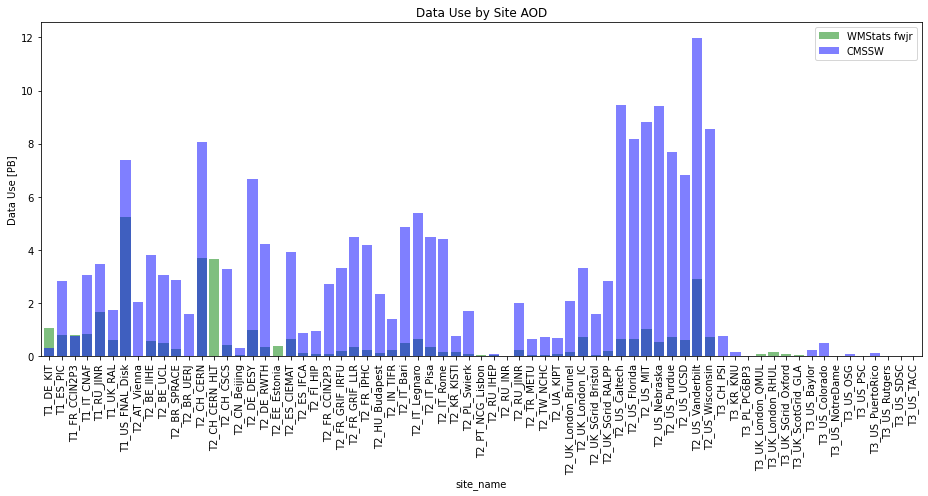

In [27]:
x = np.arange(len(combined_filt.fwjr))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
combined_filt.fwjr.plot.bar(align='center', width=0.8, label='WMStats fwjr', alpha=0.5, color='green')
combined_filt.cmssw.plot.bar(align='center', width=0.8, label='CMSSW', alpha=0.5, color='blue')

ax.set_ylabel('Data Use [PB]')
ax.set_title('Data Use by Site AOD')
ax.set_xticks(x)
ax.legend()

fig.tight_layout()
fig.savefig("plots/site_fwjr_cmssw_aod.pdf")

In [28]:
#Usage as a proportion of storage available (static and rucio)
#Give plots for both filtered and unfiltered
#Add filter for is_crab==True

#Look at how often total storage is used per site (90th percentile)
#Same as above but multiply total by 0.4 (typical use for data pop) first 
#Get variance by cite for the above as well 

##https://ncsmith.web.cern.ch/ncsmith/phedex2rucio/rucio_summary.pkl.gz

In [29]:
print('FWJR Total: ',sum(fwjr_set/1e15), ' PB')
print('CMSSW Total: ',sum(cmssw_set/1e15), ' PB')

FWJR Total:  324.68118914454897  PB
CMSSW Total:  282.06651725114597  PB


In [30]:
pd.read_pickle('https://ncsmith.web.cern.ch/ncsmith/phedex2rucio/rucio_summary.pkl.gz')

used                                            \
source                    expired      obsolete        reaper         rucio   
rse                                                                           
T1_DE_KIT_Disk       2.121648e+15  0.000000e+00  6.093404e+15  6.093404e+15   
T1_ES_PIC_Disk       9.509719e+14  0.000000e+00  2.380970e+15  2.380970e+15   
T1_FR_CCIN2P3_Disk   3.282819e+15  0.000000e+00  4.937702e+15  4.937702e+15   
T1_IT_CNAF_Disk      2.740346e+15  0.000000e+00  6.677408e+15  6.677408e+15   
T1_RU_JINR_Disk      3.453824e+15  0.000000e+00  6.876789e+15  6.876789e+15   
T1_UK_RAL_Disk       1.908123e+15  3.496440e+11  4.724927e+15  4.724927e+15   
T1_US_FNAL_Disk      1.246394e+14  8.547177e+12  2.602144e+16  2.602144e+16   
T2_AT_Vienna         2.744973e+14  0.000000e+00  3.585054e+14  3.585054e+14   
T2_BE_IIHE           2.235025e+15  0.000000e+00  3.486205e+15  3.486205e+15   
T2_BE_UCL            6.951310e+14  0.000000e+00  1.569850e+15  1.569850e+15   
T2_BR_SPRACE         1.208865e+15  0.000000e+00  1.802575e+15  1.802575e+15   
T2_BR_UERJ           1.052107e+14  0.000000e+00  2.342595e+14  2.342595e+14   
T2_CH_CERN           0.000000e+00  0.000000e+00  1.240527e+16  1.240527e+16   
T2_CH_CSCS           3.246069e+14  0.000000e+00  1.091148e+15  1.091148e+15   
T2_CN_Beijing        2.064620e+14  0.000000e+00  3.187480e+14  3.187480e+14   
T2_DE_DESY           1.315609e+15  0.000000e+00  5.095623e+15  5.095623e+15   
T2_DE_RWTH           9.599207e+14  0.000000e+00  1.751539e+15  1.751539e+15   
T2_EE_Estonia        5.390352e+14  1.388889e+11  1.008528e+15  1.008528e+15   
T2_ES_CIEMAT         1.168203e+15  0.000000e+00  2.069372e+15  2.069372e+15   
T2_ES_IFCA           3.602068e+14  0.000000e+00  6.233875e+14  6.233875e+14   
T2_FI_HIP            6.656972e+14  0.000000e+00  8.562212e+14  8.562212e+14   
T2_FR_GRIF_IRFU      7.175262e+14  0.000000e+00  1.124971e+15  1.124971e+15   
T2_FR_GRIF_LLR       5.128618e+14  0.000000e+00  1.015957e+15  1.015957e+15   
T2_FR_IPHC           1.055081e+15  0.000000e+00  1.599726e+15  1.599726e+15   
T2_GR_Ioannina       1.010292e+14  5.320195e+09  1.325415e+14  1.325415e+14   
T2_HU_Budapest       5.051009e+14  5.272945e+08  7.769885e+14  7.769885e+14   
T2_IN_TIFR           9.198572e+14  0.000000e+00  1.448496e+15  1.448496e+15   
T2_IT_Bari           5.951578e+14  0.000000e+00  1.297975e+15  1.297975e+15   
T2_IT_Legnaro        1.104571e+15  0.000000e+00  2.406044e+15  2.406044e+15   
T2_IT_Pisa           1.252169e+15  0.000000e+00  1.821225e+15  1.821225e+15   
T2_IT_Rome           3.263477e+14  0.000000e+00  6.041963e+14  6.041963e+14   
T2_KR_KISTI          3.925546e+14  0.000000e+00  7.076176e+14  7.076176e+14   
T2_PK_NCP            9.049867e+13  7.872737e+13  1.820488e+14  1.820488e+14   
T2_PL_Swierk         2.734109e+14  0.000000e+00  6.208045e+14  6.208045e+14   
T2_PT_NCG_Lisbon     8.379994e+13  0.000000e+00  1.748854e+14  1.748854e+14   
T2_RU_IHEP           1.790868e+14  0.000000e+00  2.692654e+14  2.692654e+14   
T2_RU_INR            1.553917e+14  2.334057e+12  2.131495e+14  2.131495e+14   
T2_RU_ITEP           2.012569e+14  5.400000e+08  2.116260e+14  2.116260e+14   
T2_RU_JINR           5.122936e+14  0.000000e+00  9.401823e+14  9.401823e+14   
T2_TR_METU           3.588383e+14  5.070738e+10  4.298427e+14  4.298427e+14   
T2_TW_NCHC           2.429130e+14  0.000000e+00  4.081898e+14  4.081898e+14   
T2_UA_KIPT           5.914346e+14  0.000000e+00  7.631541e+14  7.631541e+14   
T2_UK_London_Brunel  2.676021e+14  5.405301e+12  5.924831e+14  5.924831e+14   
T2_UK_London_IC      1.278774e+14  0.000000e+00  1.751559e+15  1.751559e+15   
T2_UK_SGrid_Bristol  8.415708e+10  8.415708e+10  1.959166e+14  1.959166e+14   
T2_UK_SGrid_RALPP    9.039966e+14  0.000000e+00  1.403394e+15  1.403394e+15   
T2_US_Florida        4.370910e+14  0.000000e+00  2.627127e+15  2.627127e+15   
T2_US_MIT            3.211499e+14  0.000000e+00  4.458902e+15  4.458902e+15   


In [31]:
crab(ws_cmssw)

,day,input_campaign,d_data_tier_id,site_name,is_crab,working_set_blocks,data_tier
0,1609459200,Run2016H-17Jul2018,31223,T2_BR_SPRACE,True,"(19105593, 19108181, 19109200, 19109262, 19113...",MINIAOD
1,1609459200,Run2018A-12Nov2019_UL2018_rsb,31223,T2_BE_UCL,True,(22237377),MINIAOD
2,1609459200,RunIISummer16MiniAODv3,31224,T2_US_Caltech,True,"(19402328, 19411223, 19423777, 19424931, 19425...",MINIAODSIM
7,1609545600,RunIISummer16MiniAODv3,31224,T2_UK_SGrid_RALPP,True,"(19610636, 19644317, 19644862, 20299061)",MINIAODSIM
8,1609632000,Run2016B-21Feb2020_ver2_UL2016_HIPM,31223,T2_IT_Rome,True,"(22366043, 22381224, 22383392)",MINIAOD
...,...,...,...,...,...,...,...
548342,1625961600,Run2017C-UL2017_MiniAODv2,31223,T2_UK_SGrid_RALPP,True,(23562410),MINIAOD
548343,1625961600,RunIISummer20UL16MiniAOD,31224,T2_IT_Bari,True,"(23592864, 23595039, 23600587)",MINIAODSIM
548345,1625961600,RunIISummer20UL18MiniAOD,31224,T2_UK_London_Brunel,True,"(23560686, 23609492, 23613324, 23613329, 23615...",MINIAODSIM
548347,1626048000,Run2017B-09Aug2019_UL2017,9,T1_RU_JINR,True,(21311298),AOD


In [32]:
ws_cmssw[ws_cmssw['data_tier'].str.match('(|MINI|NANO)AOD')]

,day,input_campaign,d_data_tier_id,site_name,is_crab,working_set_blocks,data_tier
0,1609459200,Run2016H-17Jul2018,31223,T2_BR_SPRACE,True,"(19105593, 19108181, 19109200, 19109262, 19113...",MINIAOD
1,1609459200,Run2018A-12Nov2019_UL2018_rsb,31223,T2_BE_UCL,True,(22237377),MINIAOD
2,1609459200,RunIISummer16MiniAODv3,31224,T2_US_Caltech,True,"(19402328, 19411223, 19423777, 19424931, 19425...",MINIAODSIM
3,1609459200,RunIISummer20UL16RECOAPV,21,T2_IT_Legnaro,None,"(23536551, 23547772, 23548940, 23549360, 23550...",AODSIM
5,1609545600,Run2016E-21Feb2020_UL2016_HIPM,9,T2_CH_CERN,None,(22025096),AOD
...,...,...,...,...,...,...,...
548347,1626048000,Run2017B-09Aug2019_UL2017,9,T1_RU_JINR,True,(21311298),AOD
548348,1626048000,Run2017B-UL2017_MiniAODv2,31223,T2_IT_Bari,None,(23571630),MINIAOD
548349,1626048000,Run2017B-UL2017_MiniAODv2,31223,T2_US_Wisconsin,None,"(23561606, 23566570, 23672247)",MINIAOD
548350,1626048000,Run2017E-UL2017_MiniAODv2,31223,T2_ES_CIEMAT,None,(23539146),MINIAOD


In [33]:
cmssw_set_filt_crab

site_name
T1_DE_KIT                699322804771049
T1_ES_PIC               2603665674545205
T1_FR_CCIN2P3            838757703794774
T1_IT_CNAF              3329136837132834
T1_RU_JINR              3543601749054879
T1_UK_RAL               1965083664033330
T1_US_FNAL_Disk         5239331919236896
T2_AT_Vienna            2516056200780871
T2_BE_IIHE              4832168571317044
T2_BE_UCL               3657526246200943
T2_BR_SPRACE            3539994533366528
T2_BR_UERJ              1790522939779466
T2_CH_CERN              9972095507576320
T2_CH_CSCS              5300628872521309
T2_CN_Beijing            261829601611868
T2_DE_DESY              8961867032411832
T2_DE_RWTH              6925258084859685
T2_ES_CIEMAT            5055741782821730
T2_ES_IFCA               900909822037808
T2_FI_HIP               1435962582970310
T2_FR_CCIN2P3           4112397628159483
T2_FR_GRIF_IRFU         4649277166138081
T2_FR_GRIF_LLR          6967098561055060
T2_FR_IPHC              6289416945763874
T2_HU_